In [7]:
#pip install scikeras

In [8]:
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
dataset_path = "/content/drive/MyDrive/cell_images/cell_images"

parasitized_path = os.path.join(dataset_path, "Parasitized")
uninfected_path = os.path.join(dataset_path, "Uninfected")

In [11]:
num_samples = 1000

parasitized_files = random.sample(os.listdir(parasitized_path), num_samples)
uninfected_files = random.sample(os.listdir(uninfected_path), num_samples)

In [13]:
os.makedirs("Sampled_Parasitized")
os.makedirs("Sampled_Uninfected")


for file in parasitized_files:
    shutil.copy(os.path.join(parasitized_path, file), "Sampled_Parasitized")

for file in uninfected_files:
    shutil.copy(os.path.join(uninfected_path, file), "Sampled_Uninfected")

In [14]:
num_sampled_parasitized = len(os.listdir("Sampled_Parasitized"))
num_sampled_uninfected = len(os.listdir("Sampled_Uninfected"))

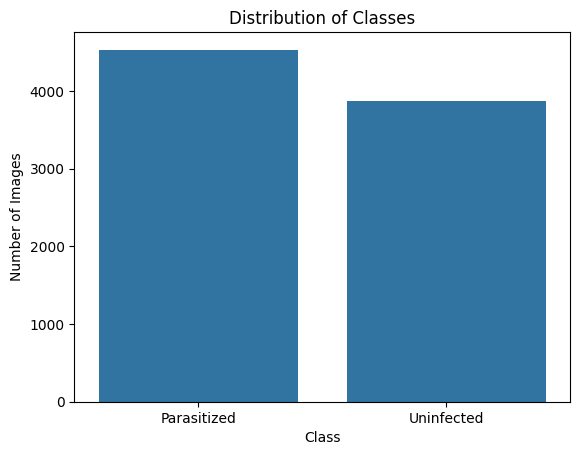

In [15]:
sns.barplot(x=["Parasitized", "Uninfected"], y=[num_sampled_parasitized, num_sampled_uninfected])
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [16]:
def display_samples(class_path, label):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = cv2.imread(os.path.join(class_path, os.listdir(class_path)[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

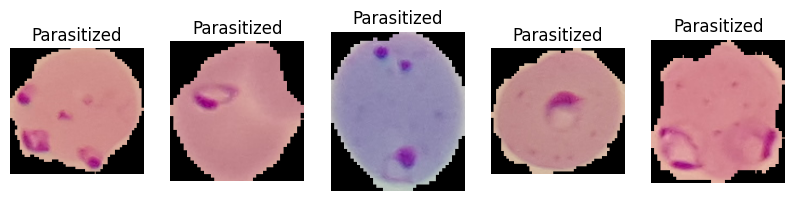

In [17]:
display_samples("Sampled_Parasitized", "Parasitized")

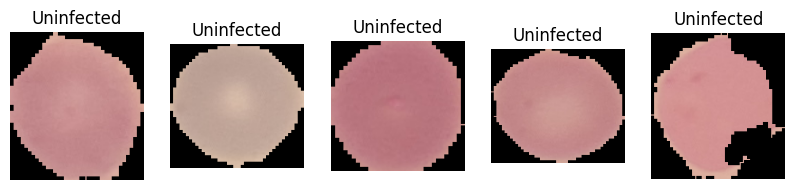

In [18]:
display_samples("Sampled_Uninfected", "Uninfected")

In [19]:
img_width, img_height = 64, 64

def preprocess_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img = load_img(os.path.join(folder_path, filename), target_size=(img_width, img_height))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

In [20]:
parasitized_images, parasitized_labels = preprocess_images("Sampled_Parasitized", label=1)
uninfected_images, uninfected_labels = preprocess_images("Sampled_Uninfected", label=0)

In [21]:
X = np.concatenate([parasitized_images, uninfected_images])
y = np.concatenate([parasitized_labels, uninfected_labels])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [23]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,458 (2.61 MB)

 Trainable params: 683,458 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.6125 - loss: 0.6486 - val_accuracy: 0.8132 - val_loss: 0.3906
Epoch 2/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.9084 - loss: 0.2660 - val_accuracy: 0.9464 - val_loss: 0.1769
Epoch 3/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 38s 219ms/step - accuracy: 0.9497 - loss: 0.1780 - val_accuracy: 0.9420 - val_loss: 0.1865
Epoch 4/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 42s 226ms/step - accuracy: 0.9511 - loss: 0.1699 - val_accuracy: 0.9546 - val_loss: 0.1528
Epoch 5/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.9589 - loss: 0.1358 - val_accuracy: 0.9509 - val_loss: 0.1558


In [27]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9453 - loss: 0.1990
Test Loss: 0.16435740888118744, Test Accuracy: 0.949404776096344


In [28]:
y_pred_prob = model.predict(X_test)

y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob[:, 1])

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step


In [29]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.9494047619047619
Precision: 0.9737142857142858
Recall: 0.9321663019693655
F1 Score: 0.9524874231414198
ROC AUC: 0.9832286852043353


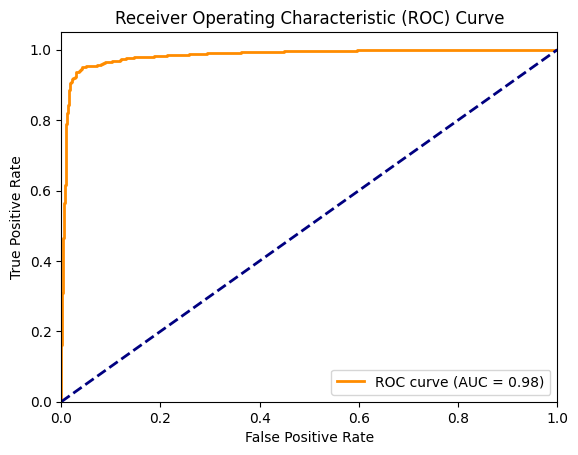

In [30]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [44]:
def create_model(optimizer='adam'):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Fixed dropout rate
        Dense(2, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [45]:
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=32, verbose=0)

param_grid = {
    'optimizer': ['adam', 'rmsprop']
}

In [46]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END .....................................optimizer=adam; total time= 3.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END .....................................optimizer=adam; total time= 3.2min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END .....................................optimizer=adam; total time= 2.9min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END ..................................optimizer=rmsprop; total time= 3.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END ..................................optimizer=rmsprop; total time= 2.9min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END ..................................optimizer=rmsprop; total time= 3.1min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
print("Best Parameters: ", grid_result.best_params_)

Best Parameters:  {'optimizer': 'adam'}
